In [1]:
%matplotlib inline
from pprint import pprint
import itertools

from market import Returns_US_1871
from simulate import simulate_withdrawals
from harvesting import N_60_RebalanceHarvesting, PrimeHarvesting
from metrics import average, mean, median
from withdrawal import ConstantDollar, EM, VPW, ECM

In [2]:
def sim2(series):
    x = simulate_withdrawals(series, years=40, withdraw=VPW, portfolio=(500000,500000))
    stocks_prime = [n.portfolio_stocks / n.portfolio_n * 100 for n in x]
    portfolio_prime = [n.portfolio_n for n in x]   
    return (stocks_prime, portfolio_prime)

def sim3(series):
    x = simulate_withdrawals(series, years=40, withdraw=EM, portfolio=(600000,400000), harvesting=N_60_RebalanceHarvesting)
    stocks_prime = [n.portfolio_stocks / n.portfolio_n * 100 for n in x]
    portfolio_prime = [n.portfolio_n for n in x]   
    return (stocks_prime, portfolio_prime)


from decimal import setcontext, ExtendedContext, Decimal
setcontext(ExtendedContext)
import math

r = Returns_US_1871()
total = 0
bondzero = 0
lowest_bonds = []
highest_bonds = []
final_port = []
failures = 0
all_bonds = []
for year in range(1871, 2015):
    y = sim2(r.iter_from(year))
    if 100 in y[0]:
        #print('Bonds hit zero in %d' % year)
        bondzero += 1
    total += 1
    lowest_bonds.append(min(y[0]))
    highest_bonds.append(max(y[0]))
    final_port.append(y[1][-1])

    def f(x):
        if math.isnan(x):
            return Decimal(0)
        else:
            return x

    all_bonds.append(average(map(f, y[0])))
    if y[1][-1] == 0:
        failures += 1
        #print("Failure in", year)
print("Hit zero bonds", bondzero, "out of", total)
print("Failures", failures, "out of", total)
print("Bond average", average(all_bonds))
print("Lowest average", average(lowest_bonds), "Highest average", average(highest_bonds))
print("Final portfolio", average(final_port))
#print(average(filter(lambda x: x != 0, lowest_bonds)))

Hit zero bonds 117 out of 144
Failures 111 out of 144
Bond average 61.1467876399
Lowest average 41.4482511222 Highest average 95.2229627021
Final portfolio 228533.728201


60.0


/home/justus/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['League Spartan'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


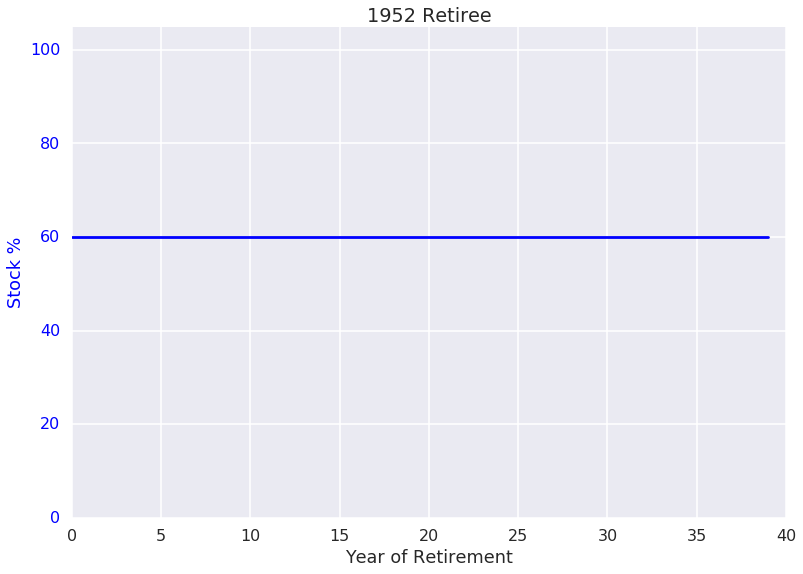

In [3]:
from plot import plot, plt, format_axis_labels_with_commas, plot_two

def p(bonds, portfolio):
    fig, ax1 = plt.subplots()
    ax1.plot(bonds, 'b')
    ax1.set_ylabel('Bonds Percentage', color='b')
    ax1.set_xlabel('Year of Retirement')
    ax1.set_ylim([0,100])
    for tl in ax1.get_yticklabels():
        tl.set_color('b')

    ax2 = ax1.twinx()
    ax2.plot(portfolio, 'g')
    ax2.set_ylabel('Portfolio Value', color='g')
    ax2.set_ylim([0,2000000])
    for tl in ax2.get_yticklabels():
        tl.set_color('g')
    format_axis_labels_with_commas(ax2.get_yaxis())

    plt.xlabel('Year of Retirement')
    plt.title('Bonds versus Portfolio')
    plt.show()


r = Returns_US_1871()
year = 1952
y = sim3(r.iter_from(year))
print(average(y[0]))
plot(y[0], y_label='Stock %', x_label='Year of Retirement', y_lim=(0,105), title='%d Retiree' % year)

40
35


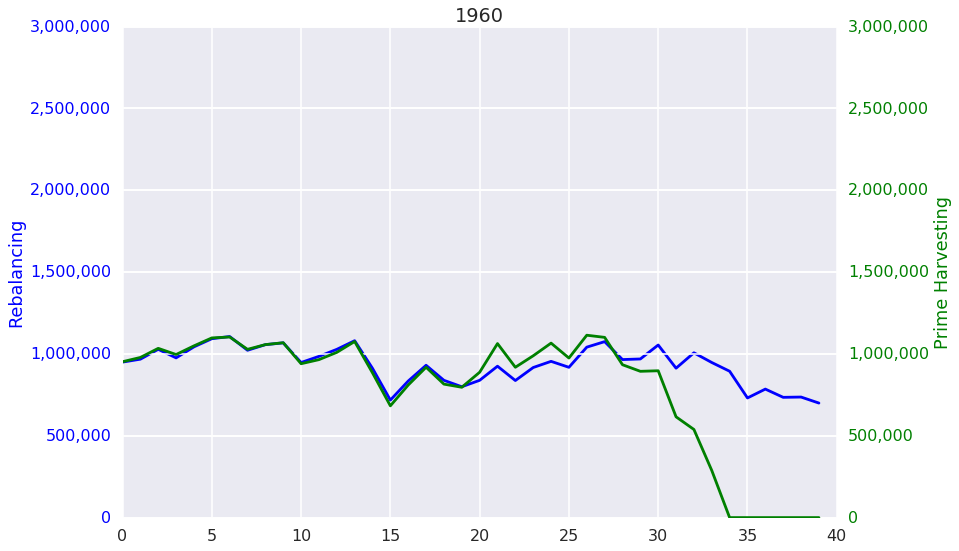

In [4]:
r = Returns_US_1871()
year = 1960
x = sim3(r.iter_from(year))
y = sim2(r.iter_from(year))

x_p = [n if not math.isnan(n) else 0 for n in x[1]]
y_p = [n if not math.isnan(n) else 0 for n in y[1]]

print(len(list(filter(lambda x: x != 0, x_p))))
print(len(list(filter(lambda x: x != 0, y_p))))

lim = None
#lim = (-3,103)
plot_two(x_p, y_p, y_lim=(0,3000000), title=year, s1_title='Rebalancing', s2_title='Prime Harvesting')

In [5]:
from harvesting import PrimeHarvesting
from withdrawal import EM
from portfolio import Portfolio

portfolio = Portfolio(392789,284434)
strategy = PrimeHarvesting(portfolio).harvest()
strategy.send(None)
withdrawal_strategy = EM(portfolio, strategy).withdrawals()
annual = []

# Withdrawals happen at the start of the year, so the first time
# we don't have any performance data to send them....
data = withdrawal_strategy.send(None)
annual.append(data)
years = 8
years -= 1

series = Returns_US_1871()

for _, d in zip(range(years), series.iter_from(2008)):
    data = withdrawal_strategy.send(d)
    annual.append(data)

for i in annual: print(i);print()


YearlyResults(returns=None, withdraw_n=Decimal('33861.15'), withdraw_r=Decimal('33861.15'), withdraw_pct_cur=Decimal('0.05'), withdraw_pct_orig=Decimal('0.05'), portfolio_n=Decimal('643361.85'), portfolio_r=Decimal('643361.85'), portfolio_bonds=Decimal('250572.85'), portfolio_stocks=Decimal('392789'))

YearlyResults(returns=Decimal('-0.206470304'), withdraw_n=Decimal('33876.3875'), withdraw_r=Decimal('33845.9262'), withdraw_pct_cur=Decimal('0.0663557562'), withdraw_pct_orig=Decimal('0.0499775203'), portfolio_n=Decimal('476650.346'), portfolio_r=Decimal('476221.746'), portfolio_bonds=Decimal('229350.392'), portfolio_stocks=Decimal('247299.954'))

YearlyResults(returns=Decimal('0.177437331'), withdraw_n=Decimal('34337.3136'), withdraw_r=Decimal('33398.0119'), withdraw_pct_cur=Decimal('0.0611826948'), withdraw_pct_orig=Decimal('0.0493161217'), portfolio_n=Decimal('526888.597'), portfolio_r=Decimal('512475.490'), portfolio_bonds=Decimal('208613.556'), portfolio_stocks=Decimal('318275.041')

In [6]:
import montecarlo
import mortality
import metrics

survival_fn = mortality.make_mortality(mortality.ANNUITY_2000)

def get_rq(portfolio, age, withdrawal_pct):
    # I can't figure out how to to joint life expectancy so I'll
    # just use female life expectancy for now :/
    life_expectancy = mortality.life_expectancy(None, age)

    stock_pct = round(portfolio.stocks_pct * 100)
    mean = montecarlo.simba_mean[stock_pct]
    stddev = montecarlo.simba_stddev[stock_pct]
    
    return metrics.probability_of_ruin(mean, stddev, life_expectancy, float(withdrawal_pct))

def simulate_risk_quotient(series,
                            portfolio=(600000, 400000),
                            harvesting=PrimeHarvesting,
                            withdraw=VPW,
                            live_until=None):
    portfolio = Portfolio(portfolio[0], portfolio[1])
    strategy = harvesting(portfolio).harvest()
    strategy.send(None)
    withdrawal_strategy = withdraw(portfolio, strategy).withdrawals()
    annual = []

    age = 65
    if not live_until:
        live_until = mortality.gen_age(survival_fn)

    # Withdrawals happen at the start of the year, so the first time
    # we don't have any performance data to send them....
    data = withdrawal_strategy.send(None)
    # Every year after the withdrawal we recalculate our risk quotient.
    rq = get_rq(portfolio, age, data.withdraw_n/data.portfolio_n)
    annual.append(rq)

    for d in series:
        age += 1
        if age > live_until:
            break

        data = withdrawal_strategy.send(d)
        rq = get_rq(portfolio, age, data.withdraw_n/data.portfolio_n)
        annual.append(rq)
    return annual

In [7]:
def simulate_wer(series,
                portfolio=(600000, 400000),
                harvesting=PrimeHarvesting,
                withdraw=VPW,
                live_until=None):
    portfolio = Portfolio(portfolio[0], portfolio[1])
    strategy = harvesting(portfolio).harvest()
    strategy.send(None)
    withdrawal_strategy = withdraw(portfolio, strategy).withdrawals()
    annual = []

    age = 65
    if not live_until:
        live_until = mortality.gen_age(survival_fn)

    # Withdrawals happen at the start of the year, so the first time
    # we don't have any performance data to send them....
    data = withdrawal_strategy.send(None)
    annual.append(data)

    for d in series:
        age += 1
        if age > live_until:
            break

        data = withdrawal_strategy.send(d)
        annual.append(data)
        
    cfs = [n.withdraw_pct_orig for n in annual]
    returns = [n.returns for n in annual]
    
    # These two sequences are not aligned. The nth element of cfs corresponds to the n+1 element
    # of returns. So we need to shift the returns list around a bit so they become aligned
    # for the WER calculations
    returns.pop(0)
    returns.append(0)

    return (metrics.cew(cfs), metrics.wer(cfs, returns), metrics.hreff(cfs, returns))

In [8]:
import pandas

df = pandas.DataFrame(columns=['RQ', 'CEW', 'WER', 'HREFF3'])
series = Returns_US_1871()
h = N_60_RebalanceHarvesting
for i in range(1871, 1990):
    (cew, wer, hreff3) = simulate_wer(series.iter_from(i), live_until=90, harvesting=h)
    rq = metrics.average(simulate_risk_quotient(series.iter_from(i), live_until=90, harvesting=h))
    df.loc[i] = [rq, cew * 1000000, wer, hreff3]
df.head()
df.to_csv('swan-primeharvesting.csv')
#df.to_csv('swan-60.csv')

,RQ,CEW,WER,HREFF3
1871,0.186210,71359.2030,1.00409049,1.22909473
1872,0.185989,71215.2360,1.04689078,1.27281985
1873,0.185979,72905.4602,1.10092654,1.33069888
1874,0.186311,74700.9365,1.09001985,1.30526435
1875,0.186435,71457.8512,1.05340439,1.23489977


0.208650225514


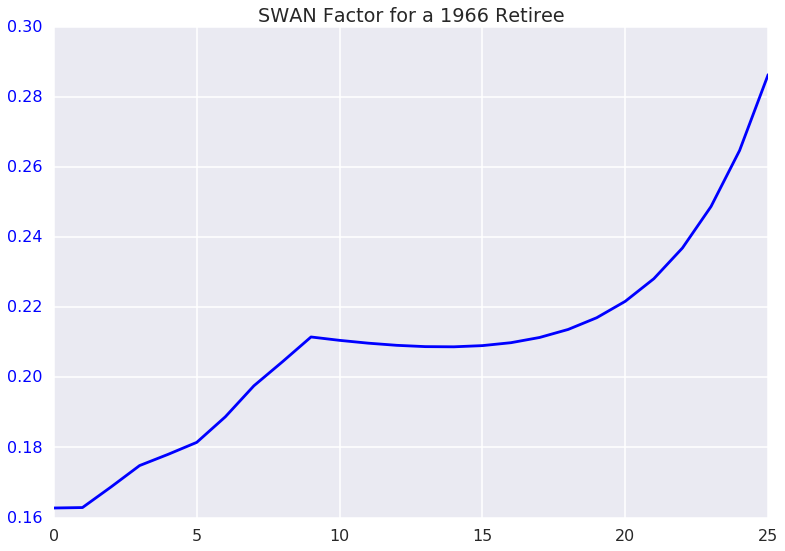

In [9]:
import pprint
r60 = simulate_risk_quotient(series.iter_from(1966), live_until=90, withdraw=ConstantDollar, harvesting=N_60_RebalanceHarvesting)
ph = simulate_risk_quotient(series.iter_from(1966), live_until=90, withdraw=VPW)

#print(metrics.average(r60))
print(metrics.average(ph))

#pprint.pprint([(a-b) for (a,b) in zip(r60, ph)])
#pprint.pprint(r60)

import plot
plot.plot(ph, title='SWAN Factor for a 1966 Retiree')